In [3]:
 # !pip install pmdarima
 # !pip install skforecast
 # !pip install awswrangler
 # !pip install holidays

In [4]:
# Librerías

# ======================================================================================
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pickle
import time
import os
from io import StringIO
import boto3
import contextlib
import re
import matplotlib.pyplot as plt
import awswrangler as wr
import holidays

#plt.style.use('seaborn-v0_8-darkgrid')
#plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('seaborn-darkgrid')

from io import BytesIO
import joblib

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings



### Puesta a punto

In [5]:
# Set up S3 client
client = boto3.client('s3')
bucket_name = 'viamericas-datalake-dev-us-east-1-283731589572-analytics'
path = 'ABTv3/' # Folder under analysis

In [6]:
##Conexion a ABT##
# Listing objects 
elements = client.list_objects(Bucket=bucket_name, Prefix=path)
# Initialize an empty list 
dfs = []
# Iterate through each CSV in the S3 path
for obj in elements.get('Contents', []):
#    print(obj)
    # Check if the object is a CSV file
    if obj['Key'].endswith('.csv'):
        # Read CSV content from S3
        response = client.get_object(Bucket=bucket_name, Key=obj['Key'])
        print(obj['Key'])
        csv_content = response['Body'].read().decode('utf-8')

        # Transform CSV content to df
        df = pd.read_csv(StringIO(csv_content))

        dfs.append(df)
final_df = pd.concat(dfs, ignore_index=True)
#Transformo fecha
final_df['date'] = pd.to_datetime(final_df['date']).dt.date

ABTv3/ABTv3.csv


### Payer

In [7]:
payer = 'ELEKTRA (MEXICO)_MEXICO'

In [8]:
final_df['date'] = pd.to_datetime(final_df['date'])

# Crear variables dummy para cada mes
for month in range(1, 13):
    month_name = f'month_{month:02d}'  # Nombre de la columna dummy
    final_df[month_name] = (final_df['date'].dt.month == month).astype(int)

In [9]:
# Celda de inicio
start_time = time.time()

In [10]:
#### SETEO EL PAYER ####
datos=final_df.loc[final_df.payer_country==payer]
#datos.head()
#datos = datos.loc[:,['amount', 'var_rate_lag_2','var_rate_lag_3','var_rate_lag_4', 'var_rate_lag_5','var_rate_lag_6','var_rate_lag_7','var_rate_lag_8','var_rate_lag_9','var_rate_lag_10','var_rate_lag_11','var_rate_lag_12','var_rate_lag_13', 'var_rate_lag_14','var_rate_lag_15','var_rate_lag_16','var_rate_lag_17','var_rate_lag_18','var_rate_lag_19','var_rate_lag_20','var_rate_lag_21', 'special_dates', 'weekend', 'ratio_coupon_tx_lag_2', 'ratio_coupon_tx_lag_3', 'ratio_coupon_tx_lag_4', 'ratio_coupon_tx_lag_5', 'ratio_coupon_tx_lag_6', 'ratio_coupon_tx_lag_7', 'ratio_coupon_tx_lag_8', 'ratio_coupon_tx_lag_9', 'ratio_coupon_tx_lag_10' ]]

In [11]:
for x in final_df.columns:
    print(x)

date
payer_country
payer
country
tx
amount
coupon_count
gp
day_x
margin
max_feed_price
rate_lag_1
rate_lag_2
rate_lag_3
rate_lag_4
rate_lag_5
rate_lag_6
rate_lag_7
rate_lag_8
rate_lag_9
rate_lag_10
rate_lag_11
rate_lag_12
rate_lag_13
rate_lag_14
rate_lag_15
rate_lag_16
rate_lag_17
rate_lag_18
rate_lag_19
rate_lag_20
rate_lag_21
rate_lag_22
rate_lag_23
rate_lag_24
rate_lag_25
rate_lag_26
rate_lag_27
rate_lag_28
rate_lag_29
rate_lag_30
var_rate_lag_1
var_rate_lag_2
var_rate_lag_3
var_rate_lag_4
var_rate_lag_5
var_rate_lag_6
var_rate_lag_7
var_rate_lag_8
var_rate_lag_9
var_rate_lag_10
var_rate_lag_11
var_rate_lag_12
var_rate_lag_13
var_rate_lag_14
var_rate_lag_15
var_rate_lag_16
var_rate_lag_17
var_rate_lag_18
var_rate_lag_19
var_rate_lag_20
var_rate_lag_21
var_rate_lag_22
var_rate_lag_23
var_rate_lag_24
var_rate_lag_25
var_rate_lag_26
var_rate_lag_27
var_rate_lag_28
var_rate_lag_29
ratio_coupon_tx
ratio_coupon_tx_lag_1
ratio_coupon_tx_lag_2
ratio_coupon_tx_lag_3
ratio_coupon_tx_lag_4
rat

In [12]:
datos = datos.set_index('date')
datos = datos.asfreq('D')

In [13]:
datos = datos[['amount', 'var_rate_lag_2','var_rate_lag_3','var_rate_lag_4', 'var_rate_lag_5',
               'var_rate_lag_6','var_rate_lag_7','var_rate_lag_8','var_rate_lag_9',
               'var_rate_lag_10','var_rate_lag_11','var_rate_lag_12','var_rate_lag_13', 
               'var_rate_lag_14','var_rate_lag_15','var_rate_lag_16','var_rate_lag_17',
               'var_rate_lag_18','var_rate_lag_19','var_rate_lag_20','var_rate_lag_21',
               'var_rate_lag_22','var_rate_lag_23','var_rate_lag_24','var_rate_lag_25',
               'var_rate_lag_26','var_rate_lag_27','var_rate_lag_28','var_rate_lag_29', 
               'ratio_coupon_tx_lag_2', 
               'ratio_coupon_tx_lag_3', 'ratio_coupon_tx_lag_4', 'ratio_coupon_tx_lag_5', 
               'ratio_coupon_tx_lag_6', 'ratio_coupon_tx_lag_7', 'ratio_coupon_tx_lag_8', 
               'ratio_coupon_tx_lag_9', 'ratio_coupon_tx_lag_10', 'ratio_coupon_tx_lag_11', 
               'ratio_coupon_tx_lag_12', 'ratio_coupon_tx_lag_13', 'ratio_coupon_tx_lag_14',
               'ratio_coupon_tx_lag_15','ratio_coupon_tx_lag_16','ratio_coupon_tx_lag_17', 
               'ratio_coupon_tx_lag_18','ratio_coupon_tx_lag_19','ratio_coupon_tx_lag_20',
               'ratio_coupon_tx_lag_21','ratio_coupon_tx_lag_22','ratio_coupon_tx_lag_23',
               'ratio_coupon_tx_lag_24','ratio_coupon_tx_lag_25','ratio_coupon_tx_lag_26',
               'ratio_coupon_tx_lag_27','ratio_coupon_tx_lag_28','ratio_coupon_tx_lag_29',
               'tx_lag_2', 'tx_lag_3','tx_lag_4', 'tx_lag_5','tx_lag_6', 'tx_lag_7', 
               'tx_lag_8', 'tx_lag_9', 'tx_lag_10', 'tx_lag_11','tx_lag_12', 'tx_lag_13',
               'tx_lag_14', 'tx_lag_15', 'tx_lag_16','tx_lag_17', 'tx_lag_18','tx_lag_19',
               'tx_lag_20', 'tx_lag_21','var_tx_cancelled_lag_2', 'var_tx_cancelled_lag_3', 
               'var_tx_cancelled_lag_4', 'var_tx_cancelled_lag_5', 'var_tx_cancelled_lag_6', 
               'var_tx_cancelled_lag_7', 'var_tx_cancelled_lag_8', 'var_tx_cancelled_lag_9', 
               'var_tx_cancelled_lag_10', 'var_tx_cancelled_lag_11', 'var_tx_cancelled_lag_12', 
               'var_tx_cancelled_lag_13', 'var_tx_cancelled_lag_14','var_tx_cancelled_lag_15', 
               'var_tx_cancelled_lag_16', 'var_tx_cancelled_lag_17', 'var_tx_cancelled_lag_18',
               'var_tx_cancelled_lag_19', 'var_tx_cancelled_lag_20','var_tx_cancelled_lag_21', 
               'var_tx_cancelled_lag_22','var_tx_cancelled_lag_23', 'var_tx_cancelled_lag_24',
               'var_tx_cancelled_lag_25', 'var_tx_cancelled_lag_26','var_tx_cancelled_lag_27', 
               'var_tx_cancelled_lag_28', 'var_tx_cancelled_lag_29',
               'margin_lag_1',
               'margin_lag_10', 'margin_lag_2', 'margin_lag_3', 'margin_lag_4', 'margin_lag_5',
               'margin_lag_6', 'margin_lag_7', 'margin_lag_8', 'margin_lag_9',
               'is_holiday',
               'var_30ds',
               'is_fourth_of_july',
#               'us_labor_day',
               'post_holiday' ]]

In [14]:
datos.shape

(1095, 119)

Fechas entrenamiento : 2021-01-01 00:00:00 --- 2023-06-30 00:00:00  (n=911)
Fechas validacion    : 2023-06-30 00:00:00 --- 2023-09-30 00:00:00  (n=93)
Fechas test          : 2023-09-30 00:00:00 --- 2023-12-31 00:00:00  (n=93)


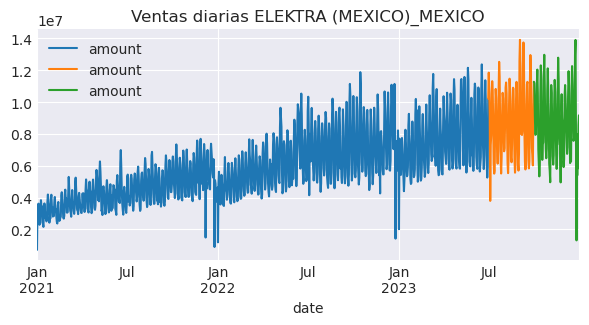

In [15]:
# Train-validation-test
# ======================================================================================
fin_train = '2023-06-30'
fin_val = '2023-09-30'
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_val].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {datos.loc[fin_val:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_val:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos[['amount']].loc[:fin_train].plot(ax=ax, label='Entrenamiento')
datos[['amount']].loc[fin_train:fin_val].plot(ax=ax, label='Validación')
datos[['amount']].loc[fin_val:].plot(ax=ax, label='test')
ax.set_title(f'Ventas diarias {payer}')
ax.legend()

In [16]:
datos.is_holiday.unique()

array([1, 0])

In [17]:
datos.index.max()

Timestamp('2023-12-31 00:00:00')

In [18]:
control=datos.loc[datos.is_holiday==1]
control.index

DatetimeIndex(['2021-01-01', '2021-01-18', '2021-05-31', '2021-06-19',
               '2021-07-04', '2021-09-06', '2021-11-11', '2021-11-25',
               '2021-12-25', '2022-01-01', '2022-01-17', '2022-05-30',
               '2022-06-19', '2022-07-04', '2022-09-05', '2022-11-11',
               '2022-11-24', '2022-12-25', '2023-01-01', '2023-01-16',
               '2023-05-29', '2023-06-19', '2023-07-04', '2023-09-04',
               '2023-11-11', '2023-11-23', '2023-12-25'],
              dtype='datetime64[ns]', name='date', freq=None)

In [19]:
fecha_filtro = ['2022-12-25','2021-12-25','2023-12-25','2021-01-01','2022-01-01','2023-01-01', ]
datos.loc[fecha_filtro, 'is_holiday'] = 0

In [20]:
fecha_filtro1 = ['2022-12-25','2021-12-25','2023-12-25']
fecha_filtro2 = ['2021-01-01','2022-01-01','2023-01-01']
datos['is_christmas']=0
datos['is_new_year']=0
datos.loc[fecha_filtro1, 'is_christmas'] = 1
datos.loc[fecha_filtro2, 'is_new_year'] = 1

In [21]:
control=datos.loc[datos.is_christmas==1]
control.index.unique()

DatetimeIndex(['2021-12-25', '2022-12-25', '2023-12-25'], dtype='datetime64[ns]', name='date', freq='365D')

In [22]:
control2=datos.loc[datos.is_holiday==1]
control2.index.unique()

DatetimeIndex(['2021-01-18', '2021-05-31', '2021-06-19', '2021-07-04',
               '2021-09-06', '2021-11-11', '2021-11-25', '2022-01-17',
               '2022-05-30', '2022-06-19', '2022-07-04', '2022-09-05',
               '2022-11-11', '2022-11-24', '2023-01-16', '2023-05-29',
               '2023-06-19', '2023-07-04', '2023-09-04', '2023-11-11',
               '2023-11-23'],
              dtype='datetime64[ns]', name='date', freq=None)

In [23]:
pd.set_option('display.max_rows', None)
datos.isna().sum()

amount                      0
var_rate_lag_2              4
var_rate_lag_3              5
var_rate_lag_4              6
var_rate_lag_5              7
var_rate_lag_6              8
var_rate_lag_7              9
var_rate_lag_8             10
var_rate_lag_9             11
var_rate_lag_10            12
var_rate_lag_11            13
var_rate_lag_12            14
var_rate_lag_13            15
var_rate_lag_14            16
var_rate_lag_15            17
var_rate_lag_16            18
var_rate_lag_17            19
var_rate_lag_18            20
var_rate_lag_19            21
var_rate_lag_20            22
var_rate_lag_21            23
var_rate_lag_22            24
var_rate_lag_23            25
var_rate_lag_24            26
var_rate_lag_25            27
var_rate_lag_26            28
var_rate_lag_27            29
var_rate_lag_28            30
var_rate_lag_29            31
ratio_coupon_tx_lag_2       2
ratio_coupon_tx_lag_3       3
ratio_coupon_tx_lag_4       4
ratio_coupon_tx_lag_5       5
ratio_coup

In [24]:
datos.fillna(0,inplace=True)

In [25]:
datos.head(3)

,amount,var_rate_lag_2,var_rate_lag_3,var_rate_lag_4,var_rate_lag_5,var_rate_lag_6,var_rate_lag_7,var_rate_lag_8,var_rate_lag_9,var_rate_lag_10,...,margin_lag_6,margin_lag_7,margin_lag_8,margin_lag_9,is_holiday,var_30ds,is_fourth_of_july,post_holiday,is_christmas,is_new_year
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,717241.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0,0,1
2021-01-02,3360407.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,1,0,0
2021-01-03,2767481.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0


In [26]:
datos.loc[fecha_filtro1, 'is_christmas'] = 1
datos.loc[fecha_filtro2, 'is_new_year'] = 1

In [27]:
exogenas=['var_rate_lag_2','var_rate_lag_3','var_rate_lag_4', 'var_rate_lag_5',
               'var_rate_lag_6','var_rate_lag_7','var_rate_lag_8','var_rate_lag_9',
               'var_rate_lag_10','var_rate_lag_11','var_rate_lag_12','var_rate_lag_13', 
               'var_rate_lag_14','var_rate_lag_15','var_rate_lag_16','var_rate_lag_17',
               'var_rate_lag_18','var_rate_lag_19','var_rate_lag_20','var_rate_lag_21',
               'var_rate_lag_22','var_rate_lag_23','var_rate_lag_24','var_rate_lag_25',
               'var_rate_lag_26','var_rate_lag_27','var_rate_lag_28','var_rate_lag_29', 
               'ratio_coupon_tx_lag_2', 
               'ratio_coupon_tx_lag_3', 'ratio_coupon_tx_lag_4', 'ratio_coupon_tx_lag_5', 
               'ratio_coupon_tx_lag_6', 'ratio_coupon_tx_lag_7', 'ratio_coupon_tx_lag_8', 
               'ratio_coupon_tx_lag_9', 'ratio_coupon_tx_lag_10', 'ratio_coupon_tx_lag_11', 
               'ratio_coupon_tx_lag_12', 'ratio_coupon_tx_lag_13', 'ratio_coupon_tx_lag_14',
               'ratio_coupon_tx_lag_15','ratio_coupon_tx_lag_16','ratio_coupon_tx_lag_17', 
               'ratio_coupon_tx_lag_18','ratio_coupon_tx_lag_19','ratio_coupon_tx_lag_20',
               'ratio_coupon_tx_lag_21','ratio_coupon_tx_lag_22','ratio_coupon_tx_lag_23',
               'ratio_coupon_tx_lag_24','ratio_coupon_tx_lag_25','ratio_coupon_tx_lag_26',
               'ratio_coupon_tx_lag_27','ratio_coupon_tx_lag_28','ratio_coupon_tx_lag_29',
               'tx_lag_2', 'tx_lag_3','tx_lag_4', 'tx_lag_5','tx_lag_6', 'tx_lag_7', 
               'tx_lag_8', 'tx_lag_9', 'tx_lag_10', 'tx_lag_11','tx_lag_12', 'tx_lag_13',
               'tx_lag_14', 'tx_lag_15', 'tx_lag_16','tx_lag_17', 'tx_lag_18','tx_lag_19',
               'tx_lag_20', 'tx_lag_21','var_tx_cancelled_lag_2', 'var_tx_cancelled_lag_3', 
               'var_tx_cancelled_lag_4', 'var_tx_cancelled_lag_5', 'var_tx_cancelled_lag_6', 
               'var_tx_cancelled_lag_7', 'var_tx_cancelled_lag_8', 'var_tx_cancelled_lag_9', 
               'var_tx_cancelled_lag_10', 'var_tx_cancelled_lag_11', 'var_tx_cancelled_lag_12', 
               'var_tx_cancelled_lag_13', 'var_tx_cancelled_lag_14','var_tx_cancelled_lag_15', 
               'var_tx_cancelled_lag_16', 'var_tx_cancelled_lag_17', 'var_tx_cancelled_lag_18',
               'var_tx_cancelled_lag_19', 'var_tx_cancelled_lag_20','var_tx_cancelled_lag_21', 
               'var_tx_cancelled_lag_22','var_tx_cancelled_lag_23', 'var_tx_cancelled_lag_24',
               'var_tx_cancelled_lag_25', 'var_tx_cancelled_lag_26','var_tx_cancelled_lag_27', 
               'var_tx_cancelled_lag_28', 'var_tx_cancelled_lag_29',
               'margin_lag_1',
               'margin_lag_10', 'margin_lag_2', 'margin_lag_3', 'margin_lag_4', 'margin_lag_5',
               'margin_lag_6', 'margin_lag_7', 'margin_lag_8', 'margin_lag_9',
               'is_holiday', 'var_30ds', 'is_fourth_of_july',
#               'us_labor_day', 
               'post_holiday','is_christmas', 'is_new_year']

In [28]:
#datos.isna().sum() # Chequeo

In [29]:
######################################################
datos[exogenas] = datos[exogenas].fillna(0) # Chequear
######################################################

In [30]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(2, 1, 1), seasonal_order=(2, 1, 1, 7))
modelo.fit(y=datos['amount'].loc[:fin_train], exog=datos[exogenas].loc[:fin_train] )
modelo.summary()
#warnings.filterwarnings("default")

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            amount   No. Observations:                  911
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood              -13116.403
Date:                           Mon, 04 Mar 2024   AIC                          26486.807
Time:                                   22:46:54   BIC                          27097.134
Sample:                               01-01-2021   HQIC                         26719.919
                                    - 06-30-2023                                         
Covariance Type:                             opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
var_rate_lag_2           9.613e+04   2.68e+05      0.359      0.719   -4.28e+05    6.21e+05
var_rate_lag_3           6.516e+04   2.23e+05      0.292      0.770   -3.72e+05    5.02e+05
var_rate_lag_4           3.434e+05   2.37e+05      1.450      0.147   -1.21e+05    8.08e+05
var_rate_lag_5           3.155e+05   2.24e+05      1.409      0.159   -1.23e+05    7.55e+05
var_rate_lag_6          -6.695e+04   2.26e+05     -0.297      0.767   -5.09e+05    3.75e+05
var_rate_lag_7          -5.061e+05   2.19e+05     -2.306      0.021   -9.36e+05    -7.6e+04
var_rate_lag_8          -3.447e+05   2.46e+05     -1.400      0.161   -8.27e+05    1.38e+05
var_rate_lag_9           -2.63e+05   1.74e+05     -1.512      0.130   -6.04e+05    7.78e+04
var_rate_lag_10         -1.136e+05   2.62e+05     -0.433      0.665   -6.27e+05       4e+05
var_rate_lag_11          1.089e+05   1.95e+05      0.559      0.576   -2.73e+05    4.91e+05
var_rate_lag_12          -2.57e+05   2.16e+05     -1.190      0.234    -6.8e+05    1.66e+05
var_rate_lag_13         -3.593e+05   2.21e+05     -1.627      0.104   -7.92e+05    7.34e+04
var_rate_lag_14         -7.296e+05   2.38e+05     -3.067      0.002    -1.2e+06   -2.63e+05
var_rate_lag_15         -6.191e+05    2.3e+05     -2.691      0.007   -1.07e+06   -1.68e+05
var_rate_lag_16         -1.906e+05   2.36e+05     -0.808      0.419   -6.53e+05    2.72e+05
var_rate_lag_17         -4.746e+05    2.3e+05     -2.067      0.039   -9.25e+05   -2.45e+04
var_rate_lag_18          2.711e+05   2.61e+05      1.040      0.298    -2.4e+05    7.82e+05
var_rate_lag_19         -3.934e+05   2.41e+05     -1.630      0.103   -8.66e+05    7.95e+04
var_rate_lag_20         -4.058e+05   2.27e+05     -1.788      0.074   -8.51e+05    3.91e+04
var_rate_lag_21         -4.699e+05    2.2e+05     -2.138      0.033   -9.01e+05   -3.91e+04
var_rate_lag_22         -3.219e+05   2.27e+05     -1.419      0.156   -7.66e+05    1.23e+05
var_rate_lag_23          2.066e+05   2.24e+05      0.924      0.355   -2.31e+05    6.45e+05
var_rate_lag_24         -5.642e+05   2.28e+05     -2.473      0.013   -1.01e+06   -1.17e+05
var_rate_lag_25          5.825e+04    2.1e+05      0.278      0.781   -3.53e+05    4.69e+05
var_rate_lag_26         -3.792e+05   2.32e+05     -1.633      0.102   -8.34e+05    7.59e+04
var_rate_lag_27         -3.955e+05    2.3e+05     -1.718      0.086   -8.47e+05    5.58e+04
var_rate_lag_28         -2.138e+05   2.21e+05     -0.966      0.334   -6.47e+05     2.2e+05
var_rate_lag_29         -2.896e+05   2.77e+05     -1.045      0.296   -8.33e+05    2.53e+05
ratio_coupon_tx_lag_2    4.965e+04   7137.996      6.956      0.000    3.57e+04    6.36e+04
ratio_coupon_tx_lag_3    2.232e+06   8216.313    271.684      0.000    2.22e+06    2.25e+06
ratio_coupon_tx_lag_4    5.045e+05   1.28e+04     39.401      0.000    4.79e+05     5.3e+05
ratio_coupon_t

In [31]:
#### !pip install lxml
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(2, 1, 1), seasonal_order=(2, 1, 1, 7))
modelo.fit(y=datos['amount'].loc[:fin_train], exog=datos[exogenas].loc[:fin_train] )
# Obtener la tabla de resumen como cadena
tabla_resumen = modelo.summary().tables[1].as_html()
# Convertir la cadena HTML en un DataFrame de pandas
df_resumen = pd.read_html(tabla_resumen, header=0, index_col=0)[0]
# Filtrar el DataFrame para quedarte solo con las filas que contienen valores p
df_valores_p = df_resumen[df_resumen.index.str.contains('P>|z|')]
# Definir el umbral de significancia
umbral_significancia = 0.05
# Filtrar las filas donde el valor p sea menor que el umbral de significancia
variables_significativas = df_valores_p[df_valores_p['P>|z|'] < umbral_significancia]
indices_variables_significativas = variables_significativas.index.tolist()
# Convertir los índices en una lista de caracteres
exogenas_total = list(map(str, indices_variables_significativas))
# Lista de exogenas filtrada
exogenas = [var for var in exogenas_total if not var.startswith(('ar.', 'ma.', 'sigma'))]
# Mostrar la lista de exogenas filtrada
print(exogenas)

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['var_rate_lag_7', 'var_rate_lag_14', 'var_rate_lag_15', 'var_rate_lag_17', 'var_rate_lag_21', 'var_rate_lag_24', 'ratio_coupon_tx_lag_2', 'ratio_coupon_tx_lag_3', 'ratio_coupon_tx_lag_4', 'ratio_coupon_tx_lag_5', 'ratio_coupon_tx_lag_6', 'ratio_coupon_tx_lag_7', 'ratio_coupon_tx_lag_8', 'ratio_coupon_tx_lag_9', 'ratio_coupon_tx_lag_10', 'ratio_coupon_tx_lag_11', 'ratio_coupon_tx_lag_12', 'ratio_coupon_tx_lag_13', 'ratio_coupon_tx_lag_14', 'ratio_coupon_tx_lag_15', 'ratio_coupon_tx_lag_16', 'ratio_coupon_tx_lag_17', 'ratio_coupon_tx_lag_18', 'ratio_coupon_tx_lag_19', 'ratio_coupon_tx_lag_20', 'ratio_coupon_tx_lag_21', 'ratio_coupon_tx_lag_22', 'ratio_coupon_tx_lag_23', 'ratio_coupon_tx_lag_24', 'ratio_coupon_tx_lag_26', 'ratio_coupon_tx_lag_27', 'ratio_coupon_tx_lag_28', 'ratio_coupon_tx_lag_29', 'tx_lag_2', 'tx_lag_3', 'tx_lag_4', 'tx_lag_7', 'tx_lag_8', 'tx_lag_9', 'tx_lag_10', 'tx_lag_11', 'tx_lag_16', 'margin_lag_5', 'var_30ds', 'is_fourth_of_july', 'post_holiday', 'is_christmas', 

/tmp/ipykernel_17/4208810970.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_resumen = pd.read_html(tabla_resumen, header=0, index_col=0)[0]


In [32]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
resultados_autoarima = auto_arima(
            y                 = datos['amount'].loc[:fin_val],
            exog              = datos[exogenas].loc[:fin_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            #test              = 'adf',
            m                 = 7, # periodicidad de la estacionalidad
            #d                 = 1, # El algoritmo determina 'd' (lo obligo porque claramente es no estacionario)
            #D                 = 1, # El algoritmo determina 'D' (idem arriba)
            max_d             = 2,
            max_D             = 2,
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
opt_order_2 = resultados_autoarima.order
opt_seasonal_order_2 = resultados_autoarima.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=30680.749, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=31379.432, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=30690.915, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=30929.594, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=31377.480, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=30953.472, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=30742.742, Time=0.09 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=30673.885, Time=0.50 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=30723.451, Time=0.22 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=30671.382, Time=0.61 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=30670.506, Time=0.44 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=30865.481, Time=0.25 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=30610.681, Time=0.58 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=30833.077, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1

In [33]:
# forecaster_autoarima = ForecasterSarimax(
#                  regressor=Sarimax(order=opt_order_2, seasonal_order=opt_seasonal_order_2)
#              )
# metrica_autoarima, predicciones_autoarima = backtesting_sarimax(
#                                 forecaster            = forecaster_autoarima,
#                                 y                     = datos['amount'],
#                                 exog                  = datos[exogenas],
#                                 initial_train_size    = len(datos.loc[:fin_val]),
#                                 steps                 = 2,
#                                 metric                = 'mean_absolute_percentage_error',
#                                 refit                 = True,
#                                 n_jobs                = 'auto',
#                                 suppress_warnings_fit = True,
#                                 verbose               = False,
#                                 show_progress         = True
#                             )
# # Predicción
# nueva_fecha = datetime.strptime(fin_val, '%Y-%m-%d') + timedelta(days=1)
# predicciones_autoarima = predicciones_autoarima['pred']

# # Combinar los dos DataFrames en uno
# resultados_predichos_autoarima= pd.DataFrame({'date': predicciones_autoarima.index, 'valor_real': datos['amount'].loc[nueva_fecha:], 'valor_predicho': predicciones_autoarima})
# # Calcular el MAPE
# resultados_predichos_autoarima['mape'] = abs((resultados_predichos_autoarima['valor_real'] - resultados_predichos_autoarima['valor_predicho']) / resultados_predichos_autoarima['valor_real']) * 100
# resultados_predichos_autoarima['error_abs'] = abs((resultados_predichos_autoarima['valor_real'] - resultados_predichos_autoarima['valor_predicho']))
# # Calcular el promedio de la columna 'mape'
# promedio_mape_autoarima = resultados_predichos_autoarima['mape'].mean()
# promedio_error_abs_autoarima = resultados_predichos_autoarima['error_abs'].mean()
# # Imprimir el promedio
# print("Promedio de la columna 'mape':", promedio_mape_autoarima)
# print("Promedio de la columna 'error_abs':", promedio_error_abs_autoarima)

In [35]:
# Cargar los modelos .pkl
with open('MODEL_WALMART (UT)_MEXICO.pkl', 'rb') as file:
    modelo_entrenado = pickle.load(file)


In [36]:
print(modelo_entrenado)

ForecasterSarimax 
Regressor: Sarimax(6,1,4)(0,0,2)[7] 
Regressor parameters: {'concentrate_scale': False, 'dates': None, 'disp': False, 'enforce_invertibility': True, 'enforce_stationarity': True, 'freq': None, 'hamilton_representation': False, 'maxiter': 50, 'measurement_error': False, 'method': 'lbfgs', 'missing': 'none', 'mle_regression': True, 'order': (6, 1, 4), 'seasonal_order': (0, 0, 2, 7), 'simple_differencing': False, 'sm_fit_kwargs': {}, 'sm_init_kwargs': {}, 'sm_predict_kwargs': {}, 'start_params': None, 'time_varying_regression': False, 'trend': None, 'trend_offset': 1, 'use_exact_diffuse': False, 'validate_specification': True} 
fit_kwargs: {} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Creation date: 2024-02-28 17:15:22 
Last fit date: None 
Index seen by the forecaster: N

In [ ]:
forecaster_autoarima =  modelo_entrenado

metrica_autoarima, predicciones_autoarima = backtesting_sarimax(
                                forecaster            = forecaster_autoarima,
                                y                     = datos['amount'],
                                exog                  = datos[exogenas],
                                initial_train_size    = len(datos.loc[:fin_val]),
                                steps                 = 2,
                                metric                = 'mean_absolute_percentage_error',
                                refit                 = True,
                                n_jobs                = 'auto',
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )
# Predicción
nueva_fecha = datetime.strptime(fin_val, '%Y-%m-%d') + timedelta(days=1)
predicciones_autoarima = predicciones_autoarima['pred']

# Combinar los dos DataFrames en uno
resultados_predichos_autoarima= pd.DataFrame({'date': predicciones_autoarima.index, 'valor_real': datos['amount'].loc[nueva_fecha:], 'valor_predicho': predicciones_autoarima})
# Calcular el MAPE
resultados_predichos_autoarima['mape'] = abs((resultados_predichos_autoarima['valor_real'] - resultados_predichos_autoarima['valor_predicho']) / resultados_predichos_autoarima['valor_real']) * 100
resultados_predichos_autoarima['error_abs'] = abs((resultados_predichos_autoarima['valor_real'] - resultados_predichos_autoarima['valor_predicho']))
# Calcular el promedio de la columna 'mape'
promedio_mape_autoarima = resultados_predichos_autoarima['mape'].mean()
promedio_error_abs_autoarima = resultados_predichos_autoarima['error_abs'].mean()
# Imprimir el promedio
print("Promedio de la columna 'mape':", promedio_mape_autoarima)
print("Promedio de la columna 'error_abs':", promedio_error_abs_autoarima)

  0%|          | 0/46 [00:00<?, ?it/s]

In [ ]:
# if promedio_mape_grid_search > promedio_mape_autoarima:
modelo_final = forecaster_autoarima
resultados_predichos = resultados_predichos_autoarima
mape_final = promedio_mape_autoarima
# else:
#     modelo_final = forecaster_gridsearch
#     resultados_predichos = resultados_predichos_gridsearch
#     mape_final = promedio_mape_gridsearch

In [ ]:
# Crear una carpeta llamada 'resultados' si no existe
carpeta_resultados = path+payer+'/'
print(carpeta_resultados)
try:
    client.put_object(Bucket=bucket_name, Key=(carpeta_resultados+'/'))
    print(f"Carpeta '{carpeta_resultados}' creada en el bucket '{bucket_name}'.")
except Exception as e:
    print(f"Error al crear la carpeta: {e}")
    

In [ ]:
# Convertir la columna 'date' a tipo datetime para asegurar el orden en el gráfico
resultados_predichos['date'] = pd.to_datetime(resultados_predichos['date'])

# Ordenar el DataFrame por la columna 'date'
resultados_predichos = resultados_predichos.sort_values(by='date')
# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 6))  # Ajusta los valores (ancho, alto) según tus preferencias

# Graficar los datos
plt.plot(resultados_predichos['date'], resultados_predichos['valor_real'], label='Valor Real', marker='o')
plt.plot(resultados_predichos['date'], resultados_predichos['valor_predicho'], label='Valor Predicho', marker='o')

# Agregar etiquetas y leyenda
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'{payer} - Real vs Predicho')
plt.legend()

plt.annotate(f'MAPE: {round(mape_final, 2)}', xy=(0.8, 0.98), xycoords='axes fraction',
             bbox=dict(boxstyle='square', fc='white', edgecolor='black'))
plt.savefig('Test_prueba2'+payer+'.png')

# Guarda la figura en un objeto BytesIO como archivo PNG
nombre_archivo_png = os.path.join(carpeta_resultados, 'Test_prueba2'+payer+'.png')
grafico_buffer = BytesIO()
plt.savefig(grafico_buffer, format='png')
grafico_buffer.seek(0)

# Cierra la figura actual para liberar recursos
plt.close()

# Sube el archivo PNG a S3 usando AWS Data Wrangler
wr.s3.upload(grafico_buffer, f"s3://{bucket_name}/{nombre_archivo_png}")
# Mostrar el gráfico
plt.show()

In [ ]:
#GUARDO RESULTADOS EN EXCEL

nombre_archivo_excel = os.path.join(carpeta_resultados, 'predicciones_test_prueba2'+payer+'.xlsx')
# Guarda el DataFrame en un objeto BytesIO como archivo Excel
#excel_buffer = BytesIO()
#resultados_predichos.to_excel(excel_buffer, index=False)
# Guarda el DataFrame en un archivo XLSX en S3 usando AWS Data Wrangler
wr.s3.to_excel(resultados_predichos, f"s3://{bucket_name}/{nombre_archivo_excel}", index=False)
nombre_archivo_pickle = os.path.join(carpeta_resultados, 'MODEL_prueba2'+payer+'.pkl')
# Guarda el modelo en un archivo pickle temporal
modelo_temp_file = 'MODEL_prueba2'+payer+'.pkl'
joblib.dump(modelo_final, modelo_temp_file)

# Sube el archivo pkl a S3
try:
    wr.s3.upload(modelo_temp_file, f"s3://{bucket_name}/{nombre_archivo_pickle}")
    print(f"Modelo guardado como pkl en S3: {nombre_archivo_pickle}")
    os.remove(modelo_temp_file) # Elimina el temporal
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")


In [ ]:
# Celda de finalización
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución total: {elapsed_time} segundos")